### Installs

In [1]:
# pip install seaborn
# pip install numpy==1.23.5
# pip install gym
# pip install scikit-learn
# python version: 3.9.6
# pip install gymnasium

### Imports

In [34]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

#### Helper Functions

In [ ]:
"""
Shows the distribution of data in array data. Data must be an array of integers.
"""
def distributionOfData(data):
    # Define bins
    bin_edges = np.arange(0, 11, 1)  # Bin edges at integer intervals (-4 to 4)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Create the histogram
    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label="Data Distribution")

    # Add labels and title
    plt.xlabel('Value Ranges (Standard Deviations)', fontsize=12)
    plt.ylabel('Frequency (Count of Data Points)', fontsize=12)
    plt.title('Histogram of Randomly Generated Data', fontsize=14)

    # Set x-axis ticks at bin centers
    plt.xticks(bin_centers, labels=[f"{x}" for x in bin_edges[:-1]])

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

"""
Shows the images of digits used in the data set.
"""
def showVisualDigitsData(X_data, y_data):
    # Print data
    print("Example of Data:")

    plt.imshow(X_data[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_data[0]})")
    plt.show()

"""
Shows numerical representation of each digit. Each digit is represented as a len-64 array with each value ranging between 0 an 16 where 0
correlates to black and 16 correlates to white.
"""
def showNumericalDigitsData(X_data, y_data):
    for i in range(3):
        print(f"X-value: {X_data[i]}")
        print(f"Y-Value: {y_data.data[i]}\n")

"""
Filters the dataset to include digits < max_val
"""
def filteredDigits(max_val=5):
        # Load the digits dataset
    digits = load_digits()

    # Extract the labels (target) from the dataset
    y = digits.target

    # Use np.where to find the indices of labels that are less than 5
    indices_less_than_max = np.where(y < max_val)
    
    return digits.data[indices_less_than_max], digits.target[indices_less_than_max]

"""
Gets all the digits.
"""
def allDigits():
    digits = load_digits()
    return digits.data, digits.target

"""
Creates the supervised model. no-print means no statistics for each epoch will be printed
"""
def supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=64, no_print=False):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define MLP model (warm_start=True allows incremental training)
    model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1, warm_start=True, verbose=False, batch_size=batch_size)

    # Lists to store accuracy values
    train_accuracies = []
    test_accuracies = []
    epoch_times = []  # List to store epoch times

    # Training loop
    for epoch in range(epochs):
        start_time = time.time()  # Start time of the epoch

        model.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        if not (no_print):
            print(f"Epoch {epoch+1}/{epochs} - Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
        end_time = time.time()  # End time of the epoch
        epoch_time = end_time - start_time  # Time taken for the epoch
        epoch_times.append(epoch_time)  # Store epoch time
    return model, train_accuracies, test_accuracies, epoch_times

"""
Graphs test vs training loss.
"""
def graphAccuracies(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # Create an epoch range
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Testing Accuracy", marker='s')
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

"""
Shows images of the correctly predicted digits.
"""
def showCorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    correct_indices = np.where(model_preds == y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[correct_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[correct_indices[i]]}, True: {y_test[correct_indices[i]]}")
        ax.axis('off')
    plt.show()

"""
Shows images of the incorrectly predicted digits.
"""
def showIncorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    incorrect_indices = np.where(model_preds != y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[incorrect_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[incorrect_indices[i]]}, True: {y_test[incorrect_indices[i]]}")
        ax.axis('off')
    plt.show()

"""
Creates feature importance graph.
"""
def showFeatureImportance(model, X_test, y_test):
    
    # Assuming 'model' is your trained MLPClassifier model
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Get the feature importances
    importances = result.importances_mean

    norm_importances = (importances - np.min(importances)) / (np.max(importances) - np.min(importances))

    importance_matrix = norm_importances.reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(importance_matrix, cmap='Blues')  # Using the Blues colormap

    # Add colorbar to the plot
    fig.colorbar(cax)

    # Set axis labels (just for clarity, with indices 1 to 8 for both X and Y)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(1, 9))
    ax.set_yticklabels(np.arange(1, 9))

    # Set title
    ax.set_title("Feature Importance Heatmap (Permutation Importance)")

    # Show the plot
    plt.show()

"""
Compares the average time per epoch, the max train accuracy, and the max test accuracy across many batch sizes.
"""
def compareBatchSizes(X_train, X_test, y_test, y_train, batch_sizes):
    epoch_times_list = []
    total_times_list = []
    train_accuracies_list = []
    test_accuracies_list = []
    idx = []
    
    for batch_size in batch_sizes:
        _, train_accuracies, test_accuracies, epoch_times = supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=batch_size, no_print=True)
        epoch_times_list.append(sum(epoch_times)/len(epoch_times))
        total_times_list.append(sum(epoch_times))
        test_accuracies_list.append(max(test_accuracies))
        train_accuracies_list.append(max(train_accuracies))
        idx.append(batch_size)

    createPlot(idx, epoch_times_list, "# Batches", "Time (sec)", "Average Training Time per Batch #")
    createPlot(idx, train_accuracies_list, "# Batches", "Max Train Accuracy", "Max Train Accuracy per Batch #")
    createPlot(idx, test_accuracies_list, "# Batches", "Max Test Accuracy", "Max Test Accuracy per Batch #")
    createPlot(idx, total_times_list, "# Batches", "Total Training Time (sec)", "Total Training Time per Batch #")

"""
Helper function to create plots.
"""
def createPlot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


### Preparing Data

In [50]:
X_data, y_data = filteredDigits()
X_train, _, y_train, _ = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_test, y_test = allDigits()

print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")


Length of training data: 720
Length of testing data: 1797


#### Your turn: Show one of the digits using above functions.

Example of Data:


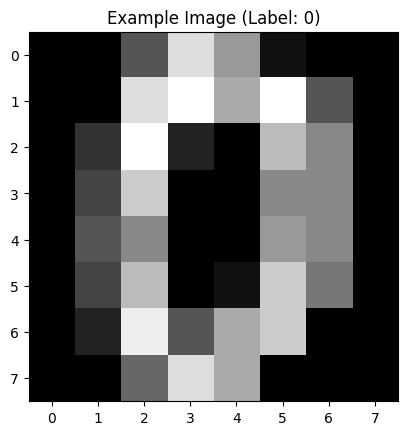

In [51]:
showVisualDigitsData(X_data, y_data)

#### Your turn: Show the numerical representations of the data. How is the image converted to a numerical representation?

In [52]:
showNumericalDigitsData(X_data, y_data)

X-value: [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
Y-Value: 0

X-value: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Y-Value: 1

X-value: [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
  8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
 15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
  5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]
Y-Value: 2



### Training Supervised Model

In [53]:
model, train_accuracies, test_accuracies, epoch_times= supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=500)


Epoch 1/10 - Training Accuracy: 0.2847, Testing Accuracy: 0.1436
Epoch 2/10 - Training Accuracy: 0.5042, Testing Accuracy: 0.2599
Epoch 3/10 - Training Accuracy: 0.7153, Testing Accuracy: 0.3634
Epoch 4/10 - Training Accuracy: 0.8264, Testing Accuracy: 0.4157
Epoch 5/10 - Training Accuracy: 0.8792, Testing Accuracy: 0.4424
Epoch 6/10 - Training Accuracy: 0.9069, Testing Accuracy: 0.4585
Epoch 7/10 - Training Accuracy: 0.9222, Testing Accuracy: 0.4663
Epoch 8/10 - Training Accuracy: 0.9361, Testing Accuracy: 0.4736
Epoch 9/10 - Training Accuracy: 0.9514, Testing Accuracy: 0.4797
Epoch 10/10 - Training Accuracy: 0.9667, Testing Accuracy: 0.4864


#### Peek into the results

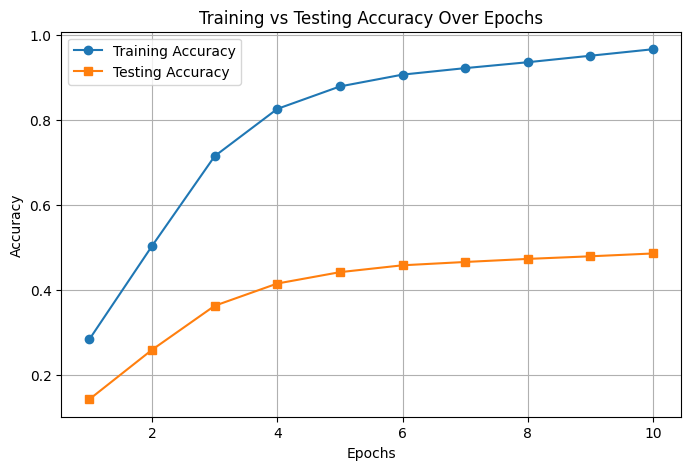

In [54]:
graphAccuracies(train_accuracies, test_accuracies)

#### Why is the model performing so badly? What can we fix?

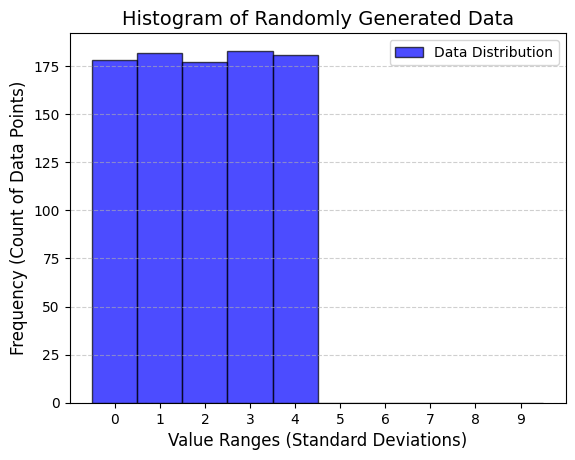

In [55]:
### Your Code
distributionOfData(y_data)

In [56]:
### Your code
X_data_updated, y_data_updated = allDigits()
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_data_updated, y_data_updated, test_size=0.2, random_state=42)

print(f"Length of training data: {len(X_train_updated)}")
print(f"Length of testing data: {len(X_test_updated)}")


Length of training data: 1437
Length of testing data: 360


#### Train model again and see results

Epoch 1/10 - Training Accuracy: 0.2443, Testing Accuracy: 0.2306
Epoch 2/10 - Training Accuracy: 0.4495, Testing Accuracy: 0.4222
Epoch 3/10 - Training Accuracy: 0.6235, Testing Accuracy: 0.5500
Epoch 4/10 - Training Accuracy: 0.7154, Testing Accuracy: 0.6861
Epoch 5/10 - Training Accuracy: 0.7669, Testing Accuracy: 0.7444
Epoch 6/10 - Training Accuracy: 0.8038, Testing Accuracy: 0.8083
Epoch 7/10 - Training Accuracy: 0.8330, Testing Accuracy: 0.8306
Epoch 8/10 - Training Accuracy: 0.8685, Testing Accuracy: 0.8611
Epoch 9/10 - Training Accuracy: 0.8852, Testing Accuracy: 0.8750
Epoch 10/10 - Training Accuracy: 0.9081, Testing Accuracy: 0.8806


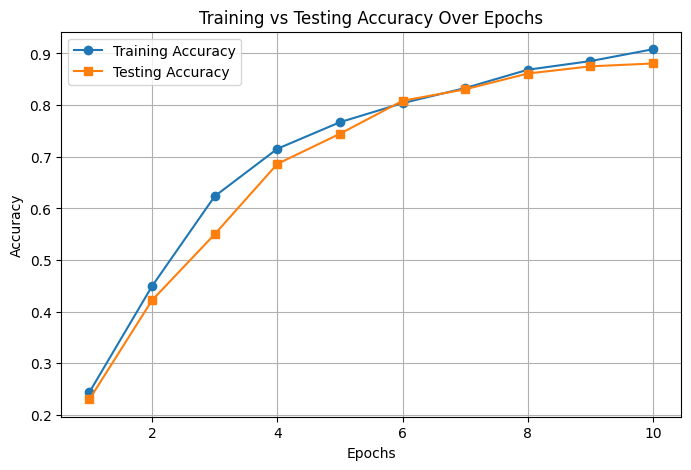

In [57]:
model, train_accuracies, test_accuracies, epoch_times= supervisedModel(X_train_updated, X_test_updated, y_test_updated, y_train_updated, epochs=10, batch_size=500)
graphAccuracies(train_accuracies, test_accuracies)

#### Deep dive into the results

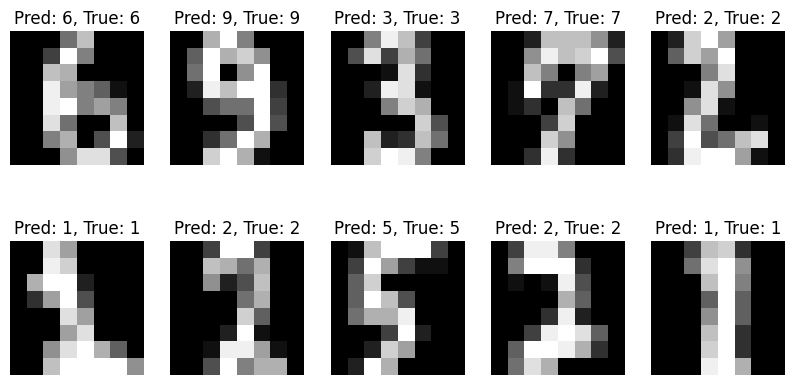

In [58]:
showCorrectPredictions(model, X_test_updated, y_test_updated)

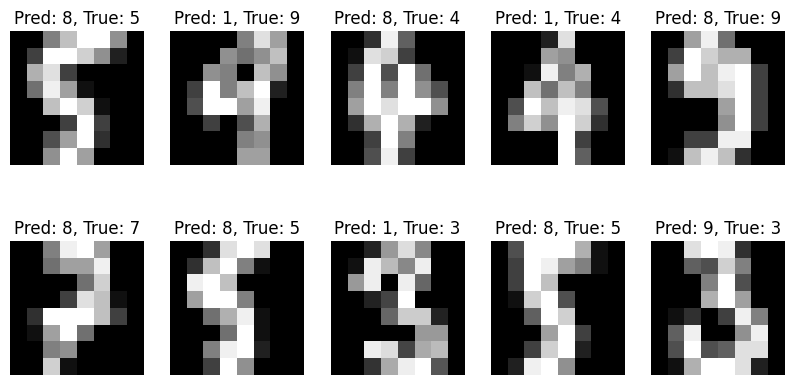

In [59]:
showIncorrectPredictions(model, X_test_updated, y_test_updated)

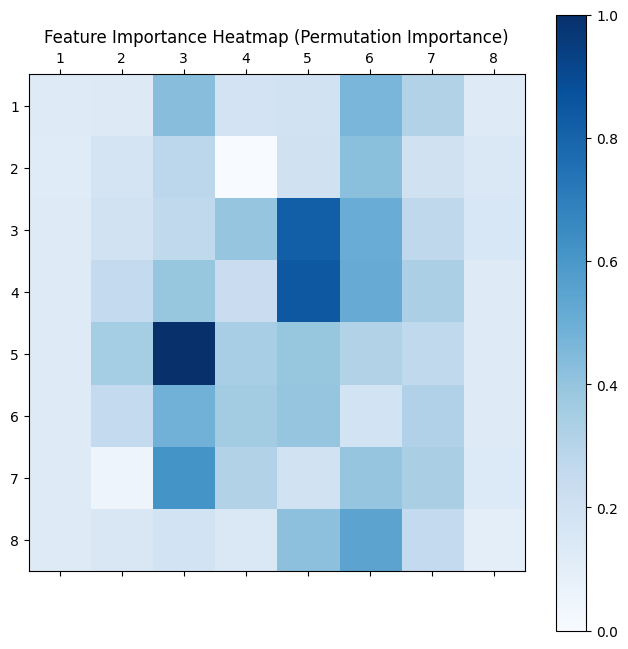

In [60]:
showFeatureImportance(model, X_test_updated, y_test_updated)

#### Your turn: Try different batch sizes. Use the above functions to see how batch size affects model performance (latency and accuracy)

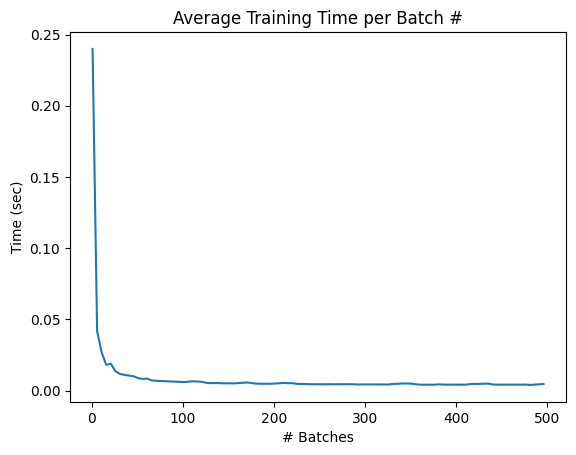

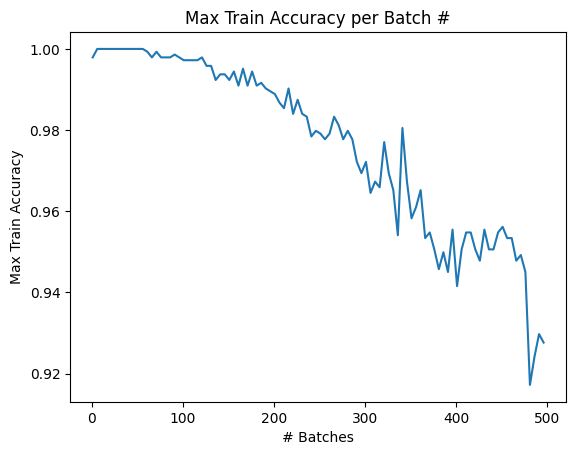

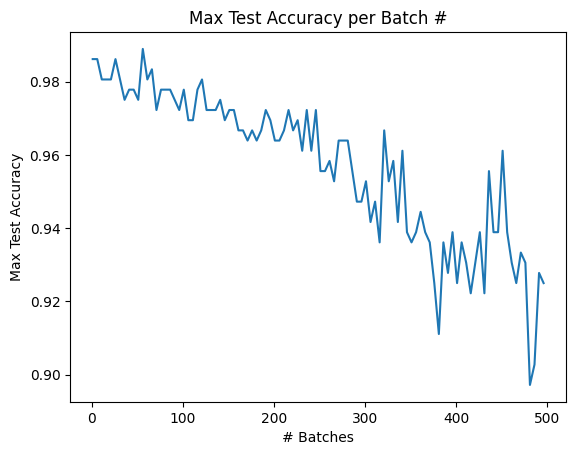

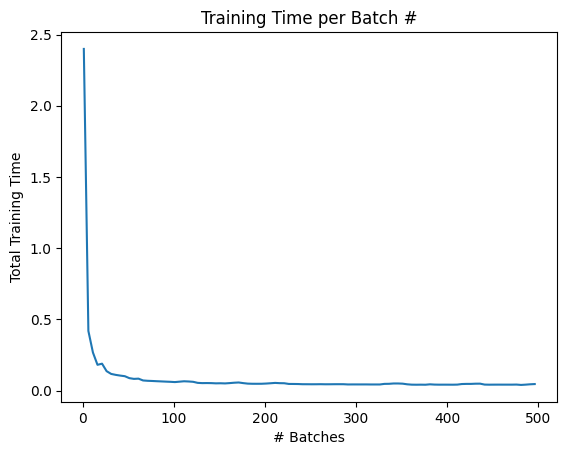

In [62]:
### Your code
compareBatchSizes(X_train_updated, X_test_updated, y_test_updated, y_train_updated, range(1, 500, 5))